In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [3]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [4]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [5]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=400, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=400, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

inactives_train = inactives.sample(n=100000)

In [6]:
df = pd.concat([actives_train, inactives_train], ignore_index=True)

In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,4.58496,-0.517304,0.000000,-1.019600,0
1,0,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,4.39232,-0.716263,0.000000,1.043790,0
2,2,0,0,1,2,0,0,0,0,0,...,0,1,0,0,1,5.49185,-0.671214,0.363636,2.430590,0
3,1,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.12928,0.396307,0.222222,-0.080929,0
4,1,0,0,1,2,0,0,0,0,0,...,0,1,0,0,0,5.35755,-0.546225,0.193548,2.531050,0


In [8]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [9]:
y.value_counts()

0    100000
1       765
Name: activity, dtype: int64

In [10]:
import matplotlib.pyplot as plt

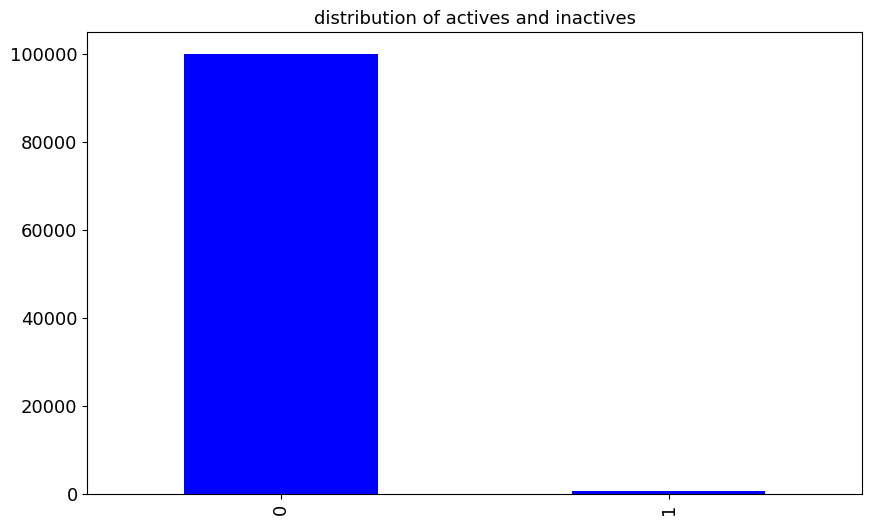

In [11]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [12]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.01, random_state=42)

In [13]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_validate = pd.DataFrame(X_validate, columns=X.columns)

### Removing low variance features to improve model performance

In [14]:
from sklearn.feature_selection import VarianceThreshold


thresh = VarianceThreshold(threshold=0.03)
thresh.fit(X_train)
mask = thresh.get_support()


X_train = X_train.loc[:, mask]
X_validatee = X_validate.loc[:, mask]

X_train.shape, X_validate.shape

((99757, 646), (1008, 777))

In [15]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [16]:
y_train_resampled.value_counts()

0    99001
1    99001
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

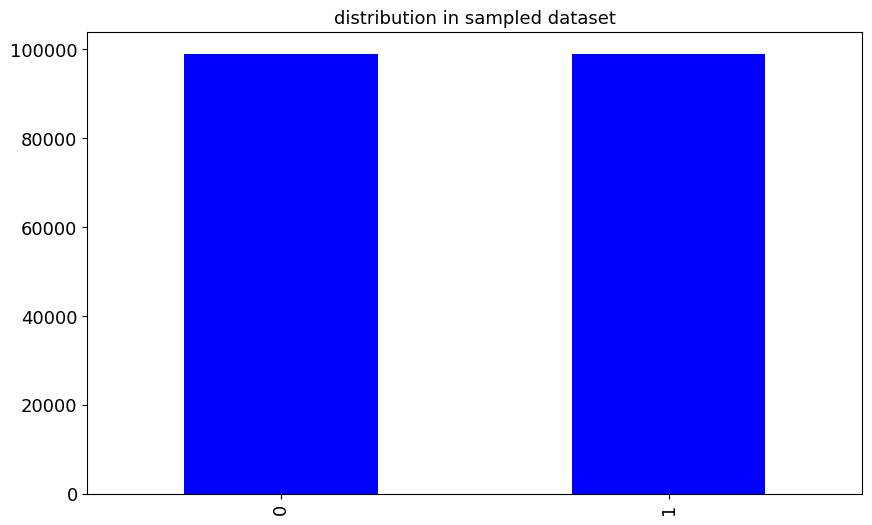

In [17]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [18]:
logistic_reg = LogisticRegression(solver='saga', max_iter=50, random_state=42, verbose=1, class_weight={0: 1, 1: 400})
logistic_reg.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 115 seconds


c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


LogisticRegression(class_weight={0: 1, 1: 400}, max_iter=50, random_state=42,
                   solver='saga', verbose=1)

### evaluating the model using the test data

In [19]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [20]:
len(testing_data)

800

In [21]:
testing_data['activity'].value_counts()

1    400
0    400
Name: activity, dtype: int64

In [22]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [23]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

800


In [24]:
testing_data_x = pd.DataFrame(testing_data_x, columns=X.columns)

In [25]:
testing_data_x = testing_data_x.loc[:, mask]

In [26]:
testing_data_x.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,-0.571374,-0.115385,-0.058661,-1.046842,-0.219957,-0.160841,-0.052011,-0.008956,-0.00708,-0.00914,...,-0.177148,-0.011847,1.255819,-0.237252,-0.052482,-0.165323,-0.037219,3.321181,-0.476149,-1.466724
1,-1.875332,-0.115385,-0.058661,-1.046842,0.807062,-0.160841,-0.052011,-0.008956,-0.00708,-0.00914,...,-0.177148,-0.011847,1.255819,-0.237252,-0.052482,-0.165323,-0.037219,-0.270247,-2.069836,-0.404991
2,0.732583,-0.115385,-0.058661,0.259233,-0.219957,-0.160841,-0.052011,-0.008956,-0.00708,-0.00914,...,-0.177148,-0.011847,-0.568298,-0.237252,-0.052482,-0.165323,0.073954,3.174306,0.998011,0.472025
3,-0.571374,-0.115385,-0.058661,1.565307,-0.219957,-0.160841,-0.052011,-0.008956,-0.00708,-0.00914,...,-0.177148,-0.011847,-0.568298,-0.237252,-0.052482,-0.165323,0.073954,0.992173,-0.535912,-0.319618
4,0.732583,-0.115385,-0.058661,-1.046842,0.807062,-0.160841,-0.052011,-0.008956,-0.00708,-0.00914,...,-0.177148,-0.011847,-0.568298,4.131071,-0.052482,-0.165323,-0.267508,0.992173,1.117538,0.302831


In [27]:
logistic_reg.predict((testing_data_x.iloc[500]).to_numpy().reshape(1, -1))

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [28]:
# converting the test dataset into a numpy array
testing_data_x = testing_data_x.to_numpy()

#### Model's accuracy on test set

In [29]:
logistic_reg.score(testing_data_x, testing_data_y)

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.7125

### evaluating model's performance with F1 score, precision, recall, etc

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
y_pred = logistic_reg.predict_proba(testing_data_x)[:, 1]
y_pred_rounded = (y_pred > 0.5).astype(int)
y_pred_rounded.shape == y_pred.shape

c:\Users\dopew\Desktop\fyp\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


True

In [32]:
testing_data_y.shape == y_pred.shape

True

In [33]:
accuracy = accuracy_score(testing_data_y, y_pred_rounded)
precision = precision_score(testing_data_y, y_pred_rounded)
recall = recall_score(testing_data_y, y_pred_rounded)
f1 = f1_score(testing_data_y, y_pred_rounded)

In [34]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.7125
precision is 0.6445578231292517
recall is 0.9475
f1 is 0.7672064777327935
